In [17]:
#imports
import os
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from mediapipe_utils.mediapipe_transforamtions import *
import numpy as np
from skimage.morphology import remove_small_holes, remove_small_objects
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from plotting import *

In [18]:
# grayscale 128
gr_model_path = 'models_grayscale_128/grayscale_128_ckp.keras'
gr_history_path = 'models_grayscale_128/grayscale_128_ckp_history.csv'
# rgb 128
rgb_model_path = 'models_rgb_128/rgb_128_larger_no_early_stopping.keras'
rgb_history_path = 'models_rgb_128/rgb_128_larger_no_early_stopping_history.csv'
# mediapipe
mp_model_path = 'models_mediapipe/cnn_mediapipe.keras'
mp_history_path = 'models_mediapipe/cnn_mediapipe_history.csv'
# unet
unet_seg_model_path = 'models_segmantation/unet_segmentation_ckp.keras'
unet_seg_history_path = 'models_segmantation/unet_segmentation_ckp_history.csv'
unet_clf_model_path = 'models_unet_classifiers/cnn_unet_classifier_100_epochs.keras'
unet_clf_history_path = 'models_unet_classifiers/cnn_unet_classifier_100_epochs_history.csv'   
# resnet
resnet_model_path = 'models_resnet/resnet_50.keras'
resnet_history_path = 'models_resnet/resnet_50_history.csv'

assert os.path.exists(gr_model_path), f"Model not found: {gr_model_path}"
assert os.path.exists(gr_history_path), f"History not found: {gr_history_path}"
assert os.path.exists(rgb_model_path), f"Model not found: {rgb_model_path}"
assert os.path.exists(rgb_history_path), f"History not found: {rgb_history_path}"
assert os.path.exists(mp_model_path), f"Model not found: {mp_model_path}"
assert os.path.exists(mp_history_path), f"History not found: {mp_history_path}"
assert os.path.exists(unet_seg_model_path), f"Model not found: {unet_seg_model_path}"
assert os.path.exists(unet_seg_history_path), f"History not found: {unet_seg_history_path}"
assert os.path.exists(unet_clf_model_path), f"Model not found: {unet_clf_model_path}"
assert os.path.exists(unet_clf_history_path), f"History not found: {unet_clf_history_path}"
assert os.path.exists(resnet_model_path), f"Model not found: {resnet_model_path}"
assert os.path.exists(resnet_history_path), f"History not found: {resnet_history_path}"

rgb_model = tf.keras.models.load_model(rgb_model_path)
gr_model = tf.keras.models.load_model(gr_model_path)
mp_model = tf.keras.models.load_model(mp_model_path)
unet_seg_model = tf.keras.models.load_model(unet_seg_model_path)
unet_clf_model = tf.keras.models.load_model(unet_clf_model_path)
resnet_model = tf.keras.models.load_model(resnet_model_path)

<Figure size 640x480 with 0 Axes>

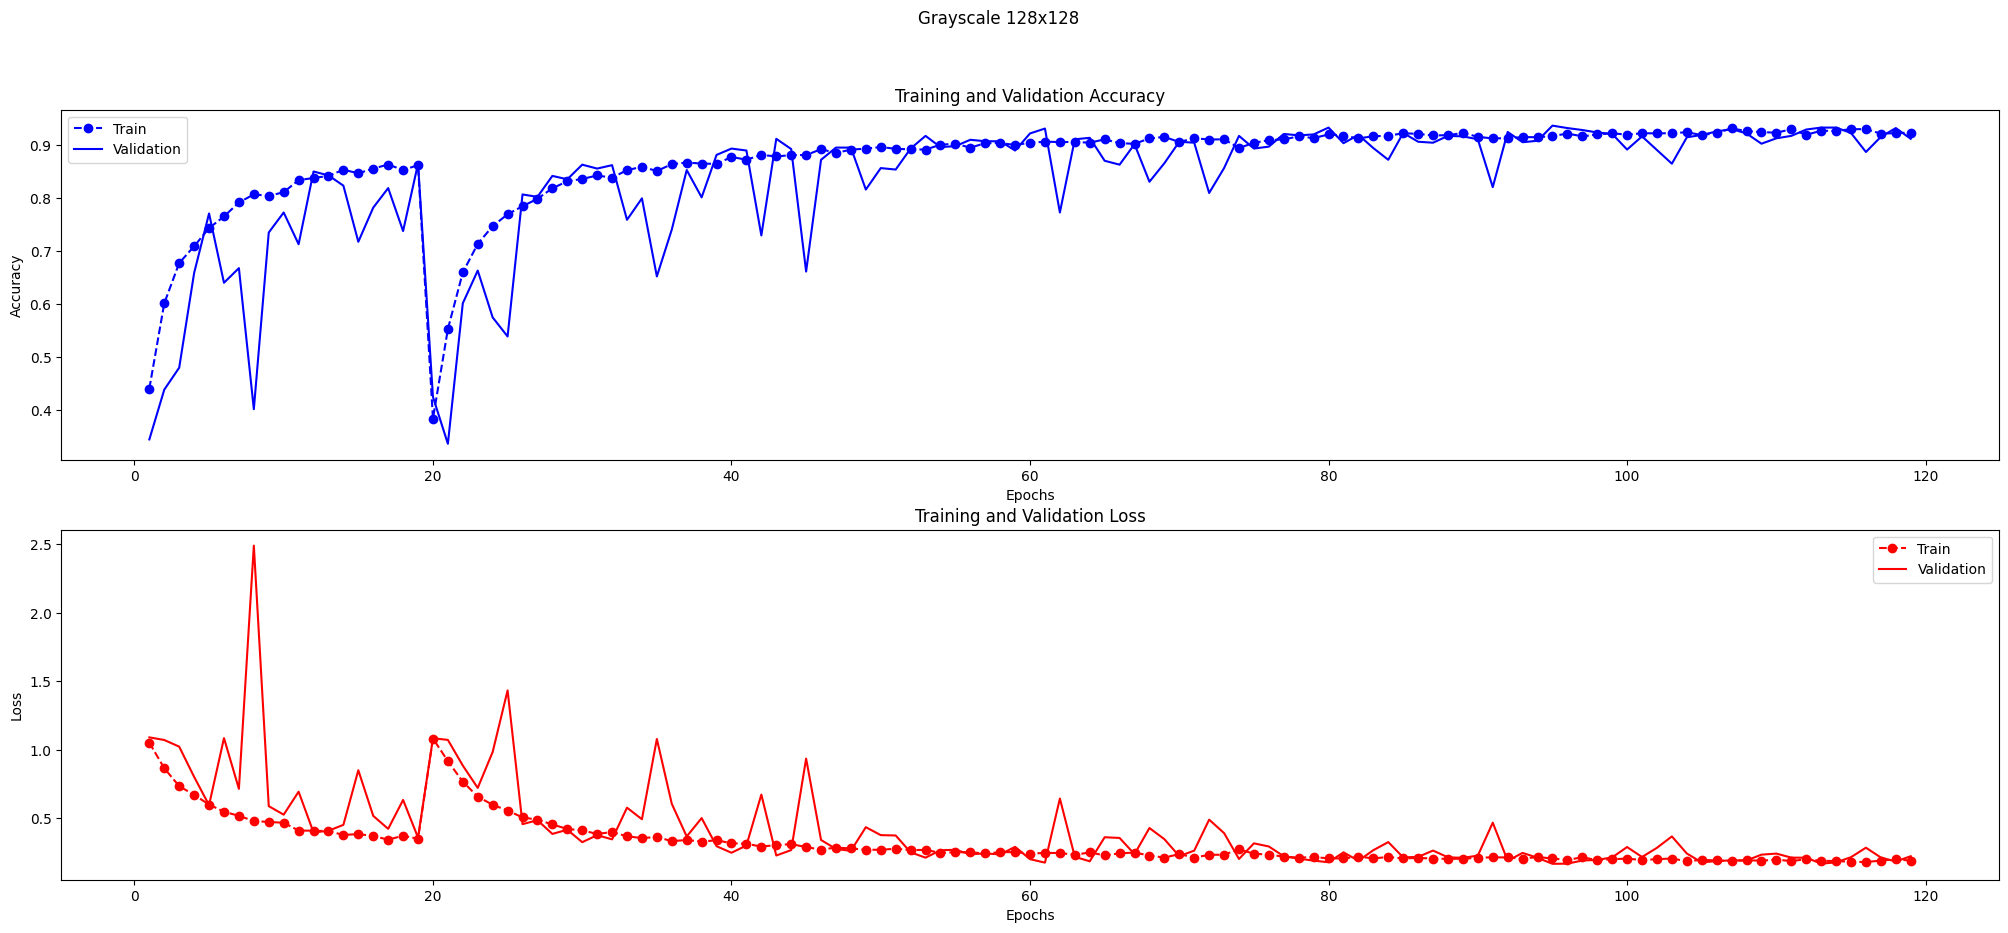

<Figure size 640x480 with 0 Axes>

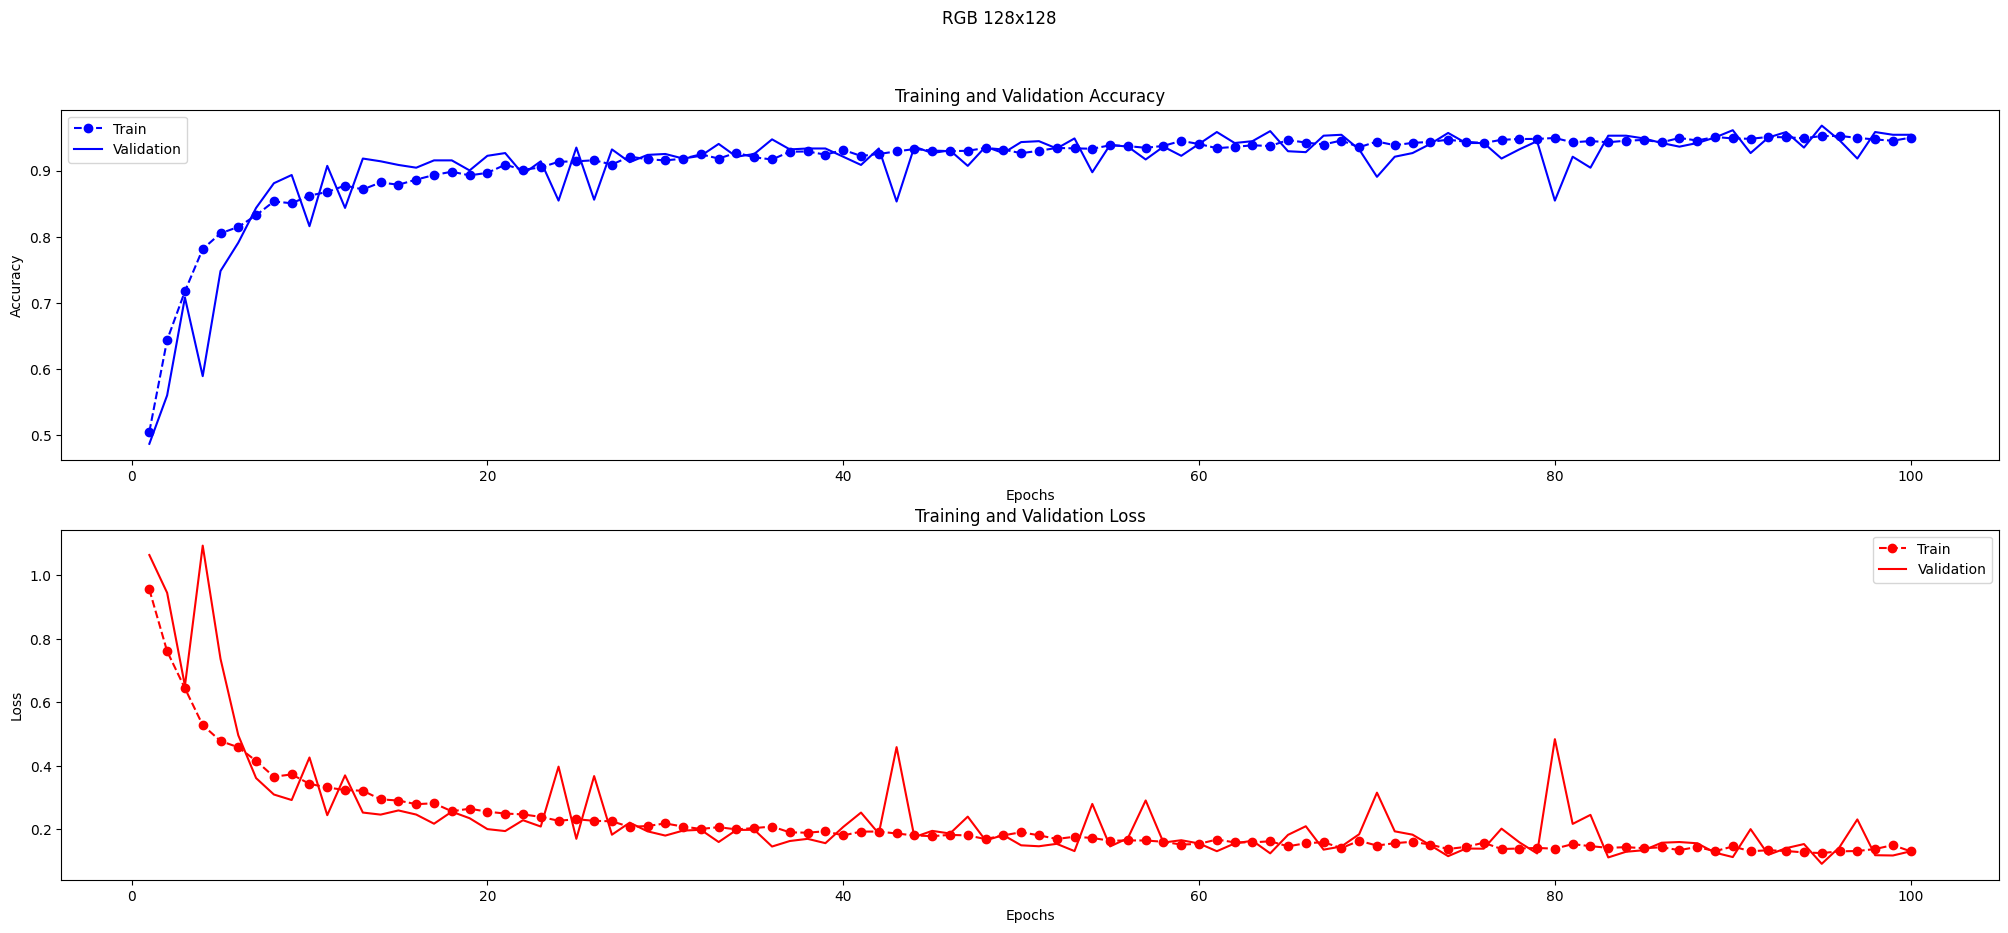

<Figure size 640x480 with 0 Axes>

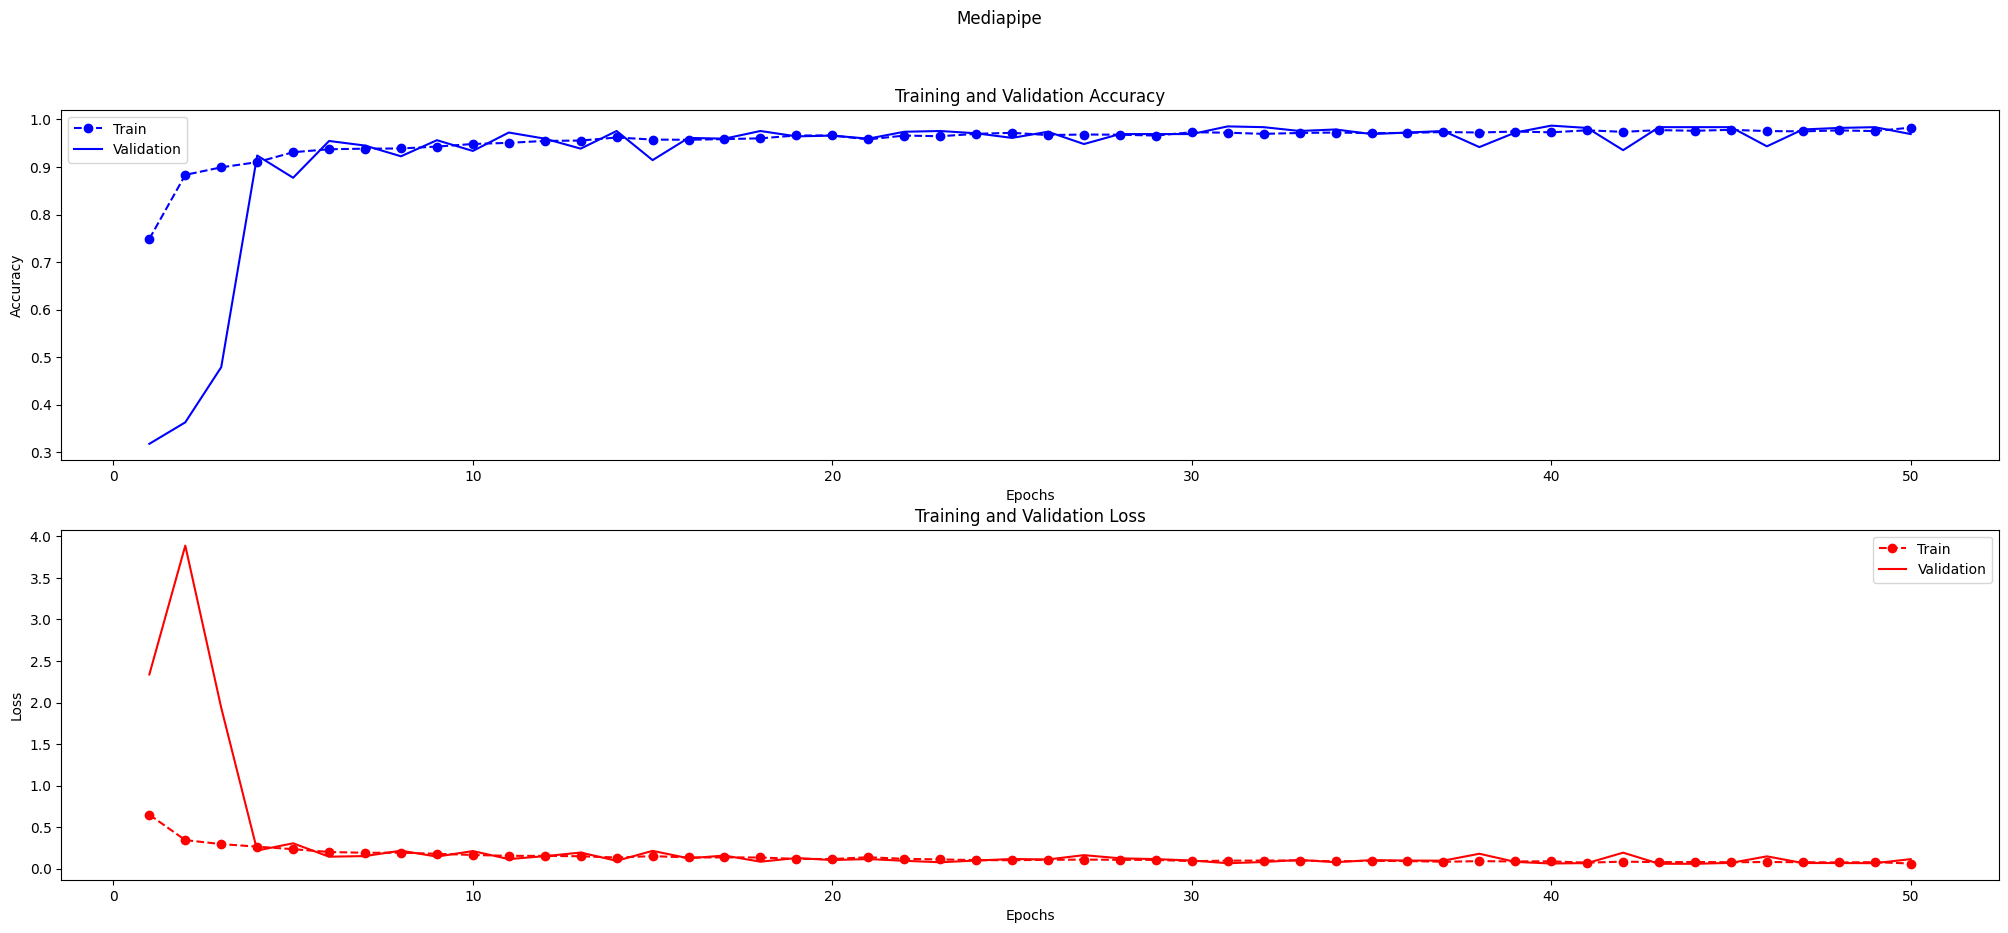

<Figure size 640x480 with 0 Axes>

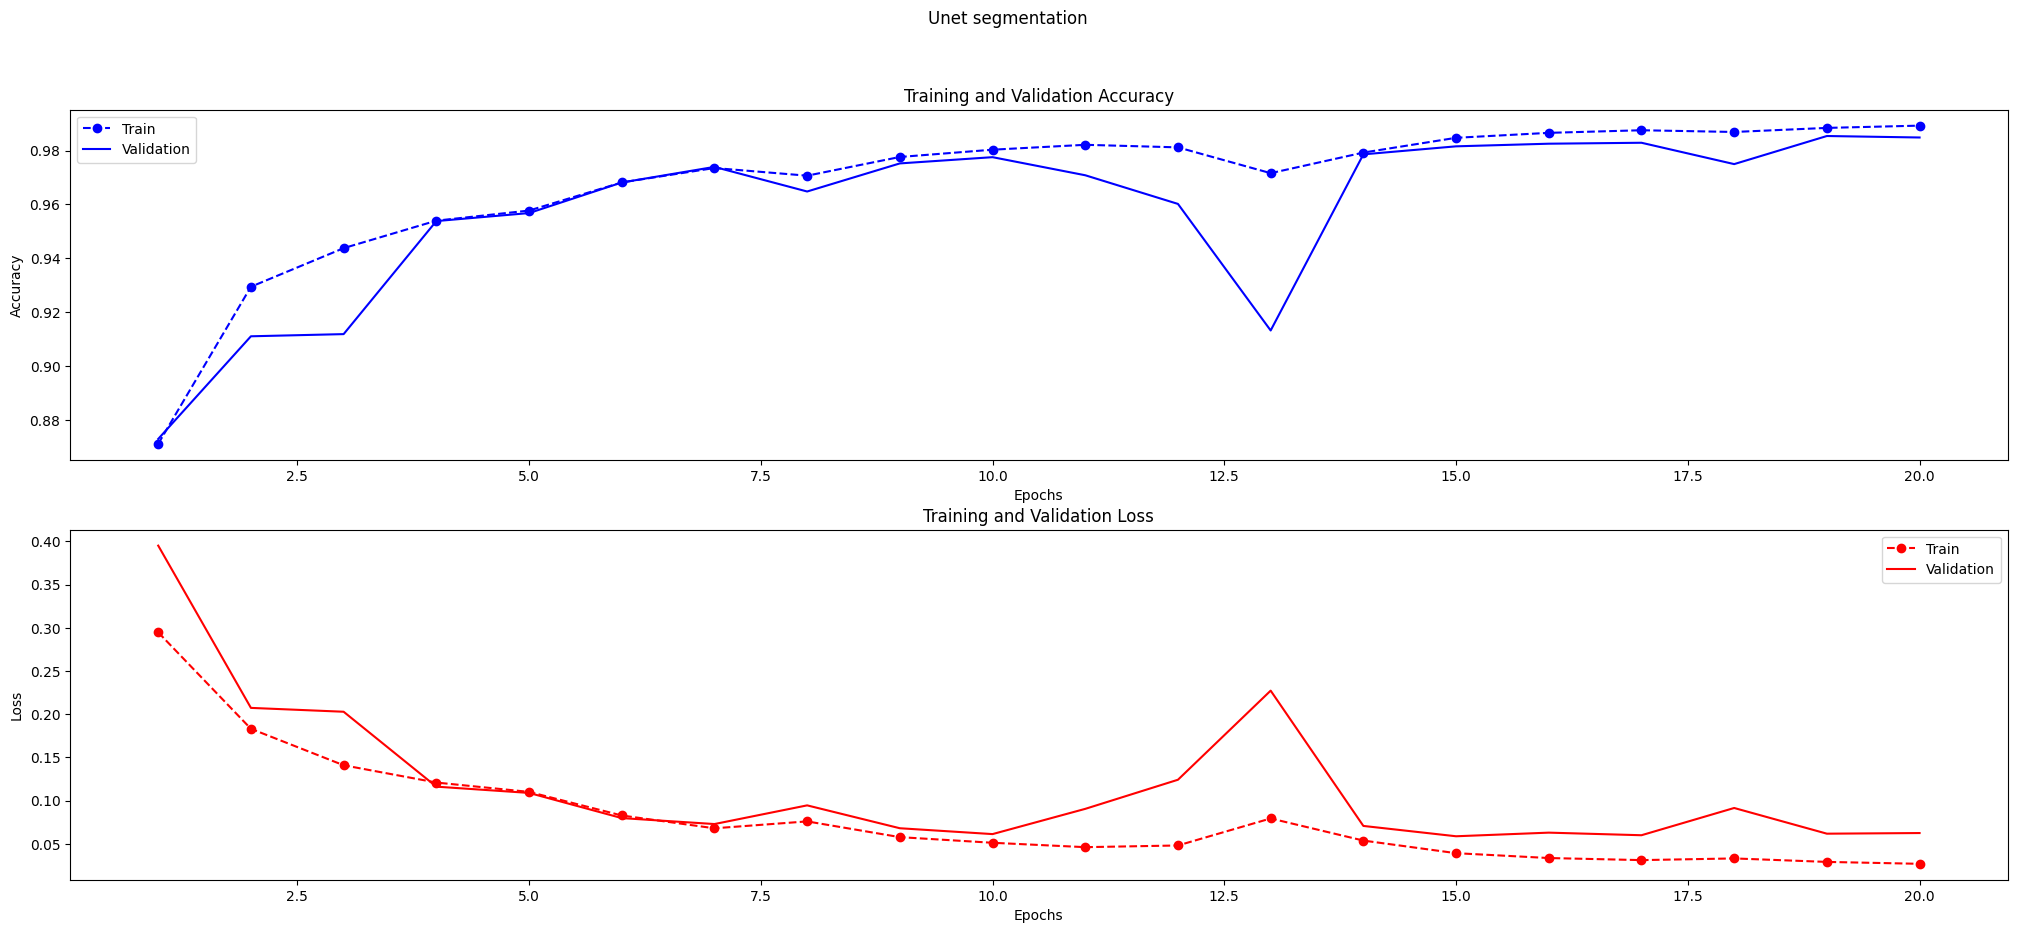

<Figure size 640x480 with 0 Axes>

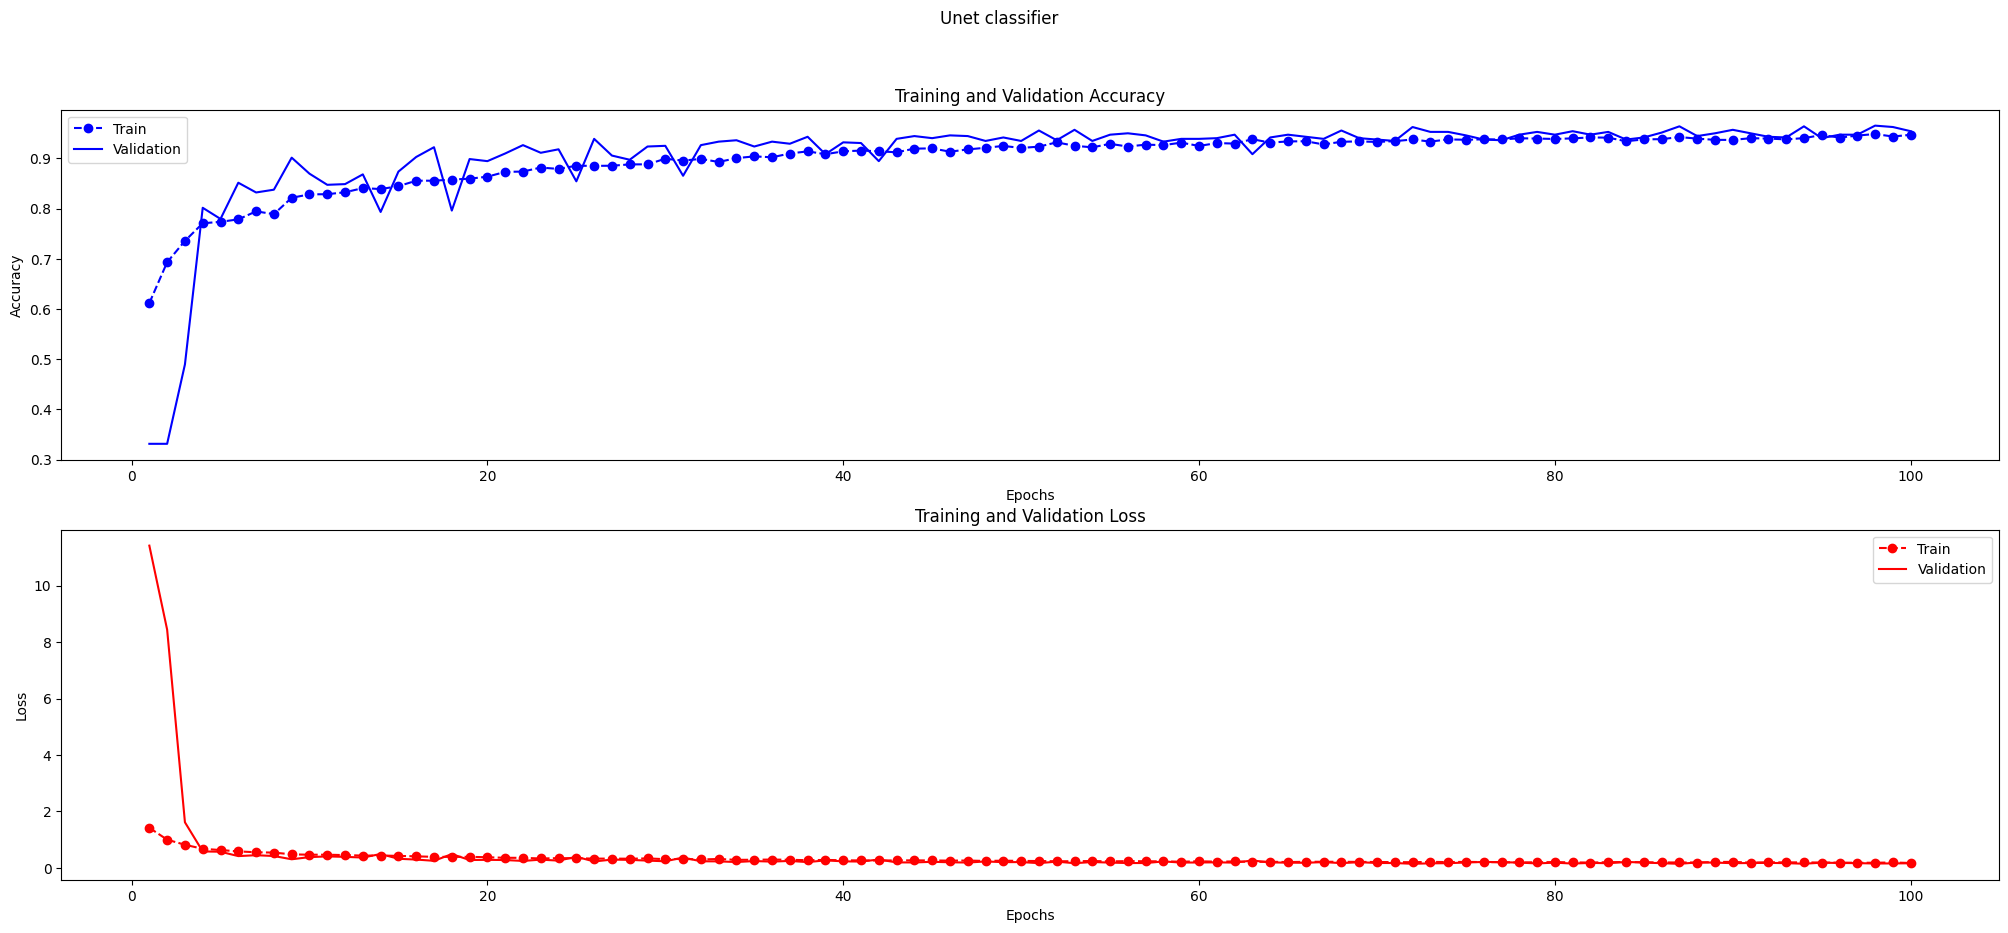

<Figure size 640x480 with 0 Axes>

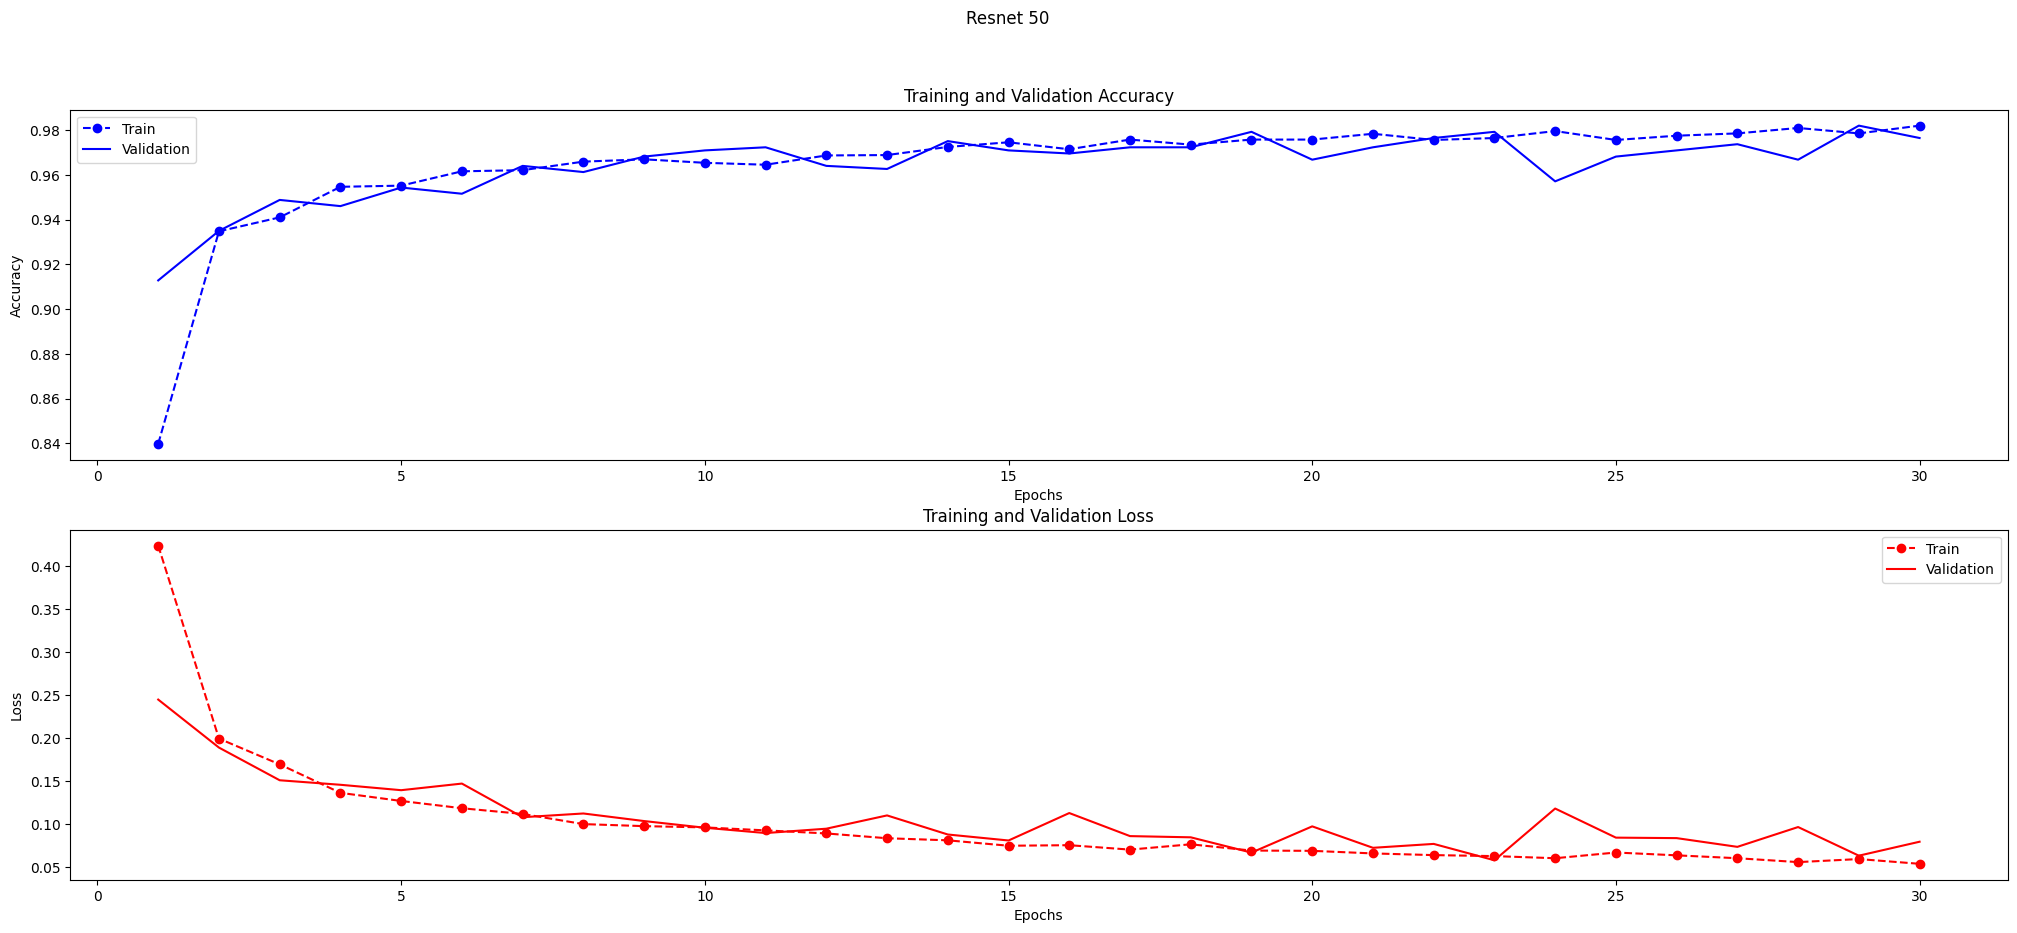

In [19]:
plot_history_csv(gr_history_path, 'Grayscale 128x128')
plot_history_csv(rgb_history_path, 'RGB 128x128')
plot_history_csv(mp_history_path, 'Mediapipe')
plot_history_csv(unet_seg_history_path, 'Unet segmentation')
plot_history_csv(unet_clf_history_path, 'Unet classifier')
plot_history_csv(resnet_history_path, 'Resnet 50')

### Testowe acc i loss dla modeli
- RGB: 
    * loss: categorical_crossentropy
    * 100 epok
    * acc: 0.9585 - loss: 0.0984
- Grayscale: 
    * loss: categorical_crossentropy
    * 100 epok
    * acc: 0.9512 - loss: 0.1397 
- Mediapipe: 
    * loss: categorical_crossentropy
    * 50 epok
    * acc: 0.9630 - loss: 0.1379
- Unet seg:
    * loss: binary_crossentropy
    * 20 epok 
    * val_acc: 0.9848 - val_loss: 0.0625
- Unet clf:
    * loss: categorical_crossentropy
    * 100 epok
    * acc: 0.9363 - loss: 0.2126  
- Resnet 50:
    * loss: categorical_crossentropy
    * 30 epok
    * acc: 0.9820 - loss: 0.0519 


In [20]:
src_data = 'predict_images'

test_dir = 'final_test'
os.makedirs(test_dir, exist_ok=True)

rgb_dst = os.path.join(test_dir, 'rgb_dataset')
os.makedirs(rgb_dst, exist_ok=True)

gr_dst = os.path.join(test_dir, 'grayscale_dataset')
os.makedirs(gr_dst, exist_ok=True)

mp_dst = os.path.join(test_dir, 'mediapipe_dataset')
os.makedirs(mp_dst, exist_ok=True)

unet_src_dir = os.path.join(test_dir, 'unet_src_data')
os.makedirs(unet_src_dir, exist_ok=True)

unet_predicted_masks_dir = os.path.join(test_dir, 'unet_predicted_masks')
os.makedirs(unet_predicted_masks_dir, exist_ok=True)

unet_dst = os.path.join(test_dir, 'unet_dataset')
os.makedirs(unet_dst, exist_ok=True)

resnet_dst = os.path.join(test_dir, 'resnet_dataset')
os.makedirs(resnet_dst, exist_ok=True)

In [21]:
CLASSES = ['rock', 'paper', 'scissors']

rgb_size = (128, 128)
gr_size = (128, 128)
mp_size = (64, 64)
unet_size = (128, 128)
resnet_size = (224, 224)

def is_folder_empty(folder):
    return len(os.listdir(folder)) == 0

def resize_and_rotate_folder(src, dst, size):
    for cls in CLASSES:
        cls_src = os.path.join(src, cls)
        cls_dst = os.path.join(dst, cls)
        os.makedirs(cls_dst, exist_ok=True)
        for img_name in os.listdir(cls_src):
            img_path = os.path.join(cls_src, img_name)
            img = Image.open(img_path)
            
            if img.height > img.width:
                img = img.rotate(90, expand=True)
            img = img.resize(size, Image.Resampling.LANCZOS)
            img.save(os.path.join(cls_dst, img_name))
            
def convert_grayscale(src, dst):
    for cls in CLASSES:
        cls_src = os.path.join(src, cls)
        cls_dst = os.path.join(dst, cls)
        os.makedirs(cls_dst, exist_ok=True)
        for img_name in os.listdir(cls_src):
            img_path = os.path.join(cls_src, img_name)
            img = Image.open(img_path).convert('L')
            
            if img.height > img.width:
                img = img.rotate(90, expand=True)
                
            img = img.resize(gr_size, Image.Resampling.LANCZOS)
            img.save(os.path.join(cls_dst, img_name))

def convert_mediapipe(src, dst):
    create_rps_mediapipe_dataset(src, dst, CLASSES, min_detection_confidence=0.4, input_shape=(224, 224), output_shape=(64, 64)) 
    
def _load_images_unet(src_dir):
    image_paths = [os.path.join(src_dir, fname) for fname in os.listdir(src_dir)]
    images = []
    filenames = []
    
    for img_path in image_paths:
        img = load_img(img_path, target_size=unet_size)
        img = img_to_array(img) / 255.0  
        images.append(img)
        filenames.append(os.path.basename(img_path))  
    return np.array(images), filenames

def _predict_unet_segmentation(src, dst):
    for class_name in CLASSES:
        total_predictions = 0
        print(f"Segmenting images from class {class_name}")
        
        image_dir = os.path.join(src, class_name)  
        output_dir = os.path.join(dst, class_name)  
        os.makedirs(output_dir, exist_ok=True)
        
        images, filenames = _load_images_unet(image_dir)
        
        predictions = unet_seg_model.predict(images)
        
        for pred, fname in zip(predictions, filenames):
            pred_mask = (pred.squeeze() > 0.5).astype(np.uint8) * 255 
            
            mask_image = Image.fromarray(pred_mask)
            mask_image = mask_image.convert("L")  
            output_path = os.path.join(output_dir, fname.replace('.jpg', '.png').replace('.jpeg', '.png')) 
            mask_image.save(output_path, format='PNG')
            total_predictions += 1
            
        print(f"Segmented {total_predictions} images from class {class_name}")    
        
def _postprocess_mask_unet(mask):
    mask[mask == 255] = 1
    assert np.all(np.isin(mask, [0, 1])), 'Mask values should be 0 or 1'
    mask_bool = mask.astype(bool)
    processed_mask = remove_small_objects(mask_bool, min_size=128)
    processed_mask = remove_small_holes(processed_mask, area_threshold=256)
    mask = processed_mask.astype(np.uint8) * 255
    return mask

def _check_if_mask_almost_empty_unet(mask):
    count_non_zero = np.count_nonzero(mask)
    if count_non_zero < 900:
        return True
    
def _postprocess_masks_unet(src, dst):
    for subfolder in os.listdir(src):
        src_subfolder = os.path.join(src, subfolder)
        dest_subfolder = os.path.join(dst, subfolder)
        os.makedirs(dest_subfolder, exist_ok=True)

        for file in os.listdir(src_subfolder):
            src_file = os.path.join(src_subfolder, file)
            dest_file = os.path.join(dest_subfolder, file)

            mask = np.array(Image.open(src_file))
            processed_mask = _postprocess_mask_unet(mask)
            if _check_if_mask_almost_empty_unet(processed_mask):
                print('Mask almost empty, skipping:', src_file)
                continue
            image = Image.fromarray(processed_mask)
            if image.mode != 'L':
                image = image.convert('L')
            image.save(dest_file)
   
    
def convert_unet(src, dst):
    if is_folder_empty(unet_src_dir):
        resize_and_rotate_folder(src, unet_src_dir, unet_size)
    if is_folder_empty(unet_predicted_masks_dir):
        _predict_unet_segmentation(unet_src_dir, unet_predicted_masks_dir)
    _postprocess_masks_unet(unet_predicted_masks_dir, unet_dst)
    

    

In [22]:
if is_folder_empty(rgb_dst):
    resize_and_rotate_folder(src_data, rgb_dst, rgb_size)
    print('RGB dataset created')

if is_folder_empty(gr_dst):
    convert_grayscale(src_data, gr_dst)
    print('Grayscale dataset created')    

if is_folder_empty(mp_dst):
    convert_mediapipe(src_data, mp_dst)
    print('Mediapipe dataset created')

if is_folder_empty(unet_dst):
    convert_unet(src_data, unet_dst)
    print('Unet dataset created')
    
if is_folder_empty(resnet_dst):
    resize_and_rotate_folder(src_data, resnet_dst, resnet_size)
    print('Resnet dataset created')

In [23]:
batch_size = 32

scaled_datagen = ImageDataGenerator(rescale=1./255)
resnet_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

rgb_test_generator = scaled_datagen.flow_from_directory(
    rgb_dst, 
    target_size=rgb_size, 
    batch_size=batch_size, 
    class_mode='categorical')

gr_test_generator = scaled_datagen.flow_from_directory(
    gr_dst, 
    target_size=gr_size, 
    batch_size=batch_size, 
    class_mode='categorical',
    color_mode='grayscale')

mp_test_generator = scaled_datagen.flow_from_directory(
    mp_dst, 
    target_size=mp_size, 
    batch_size=batch_size, 
    class_mode='categorical',
    color_mode='grayscale')

unet_test_generator = scaled_datagen.flow_from_directory(
    unet_dst, 
    target_size=unet_size, 
    batch_size=batch_size, 
    class_mode='categorical',
    color_mode='grayscale')

resnet_test_generator = resnet_datagen.flow_from_directory(
    resnet_dst, 
    target_size=resnet_size, 
    batch_size=batch_size, 
    class_mode='categorical')

Found 70 images belonging to 3 classes.
Found 70 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Found 70 images belonging to 3 classes.
Found 70 images belonging to 3 classes.


In [29]:
rgb_loss, rgb_acc = rgb_model.evaluate(rgb_test_generator, verbose=0)
gr_loss, gr_acc = gr_model.evaluate(gr_test_generator, verbose=0)
mp_loss, mp_acc = mp_model.evaluate(mp_test_generator, verbose=0)
unet_loss, unet_acc = unet_clf_model.evaluate(unet_test_generator, verbose=0)
resnet_loss, resnet_acc = resnet_model.evaluate(resnet_test_generator, verbose=0)

dst_len = 70
mp_dst_len = mp_test_generator.samples
unet_dst_len = unet_test_generator.samples

percent_not_detected_mp = (dst_len - mp_dst_len) * 100 / dst_len
percent_not_detected_unet = (dst_len - unet_dst_len) * 100 / dst_len

print('Results:\n')
print(f'RGB model: \n\tloss\t\t{rgb_loss:.4f}\n\taccuracy\t{rgb_acc*100:.2f}%')
print(f'Grayscale model: \n\tloss\t\t{gr_loss:.4f}\n\taccuracy\t{gr_acc*100:.2f}%')
print(f'Mediapipe model: \n\tloss\t\t{mp_loss:.4f}\n\taccuracy\t{mp_acc*100:.2f}%\n\n\t{percent_not_detected_mp:.2f}% of images were not detected')
if percent_not_detected_mp > 0:
    real_accuracy = mp_acc * (mp_dst_len / dst_len) * 100
    print(f'\treal accuracy: {real_accuracy:.2f}%')

print(f'Unet classifier model: \n\tloss\t\t{unet_loss:.4f}\n\taccuracy\t{unet_acc*100:.2f}%\n\n\t{percent_not_detected_unet:.2f}% of images were not detected')
if percent_not_detected_unet > 0:
    real_accuracy = unet_acc * (unet_dst_len / dst_len) * 100
    print(f'\treal accuracy\t{real_accuracy:.2f}%')
print(f'Resnet model: \n\tloss\t\t{resnet_loss:.4f}\n\taccuracy\t{resnet_acc*100:.2f}%')



Results:

RGB model: 
	loss		0.7912
	accuracy	70.00%
Grayscale model: 
	loss		0.5741
	accuracy	74.29%
Mediapipe model: 
	loss		0.0797
	accuracy	98.41%

	10.00% of images were not detected
	real accuracy: 88.57%
Unet classifier model: 
	loss		0.5470
	accuracy	85.71%

	0.00% of images were not detected
Resnet model: 
	loss		0.1709
	accuracy	95.71%


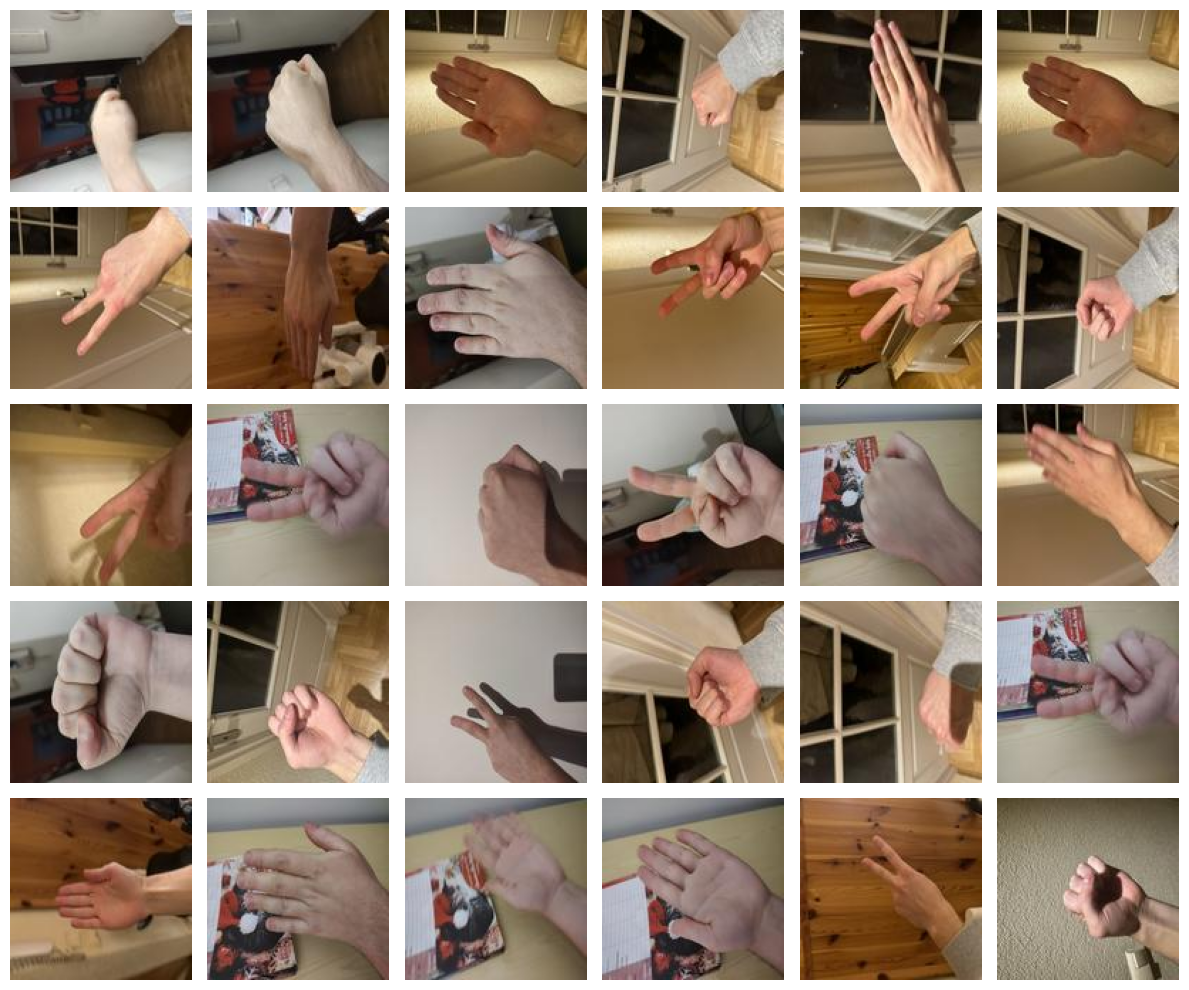

In [25]:
plot_grid_from_generator(rgb_test_generator, 5, 6)